# NLO: Non-Linear Oscillator

http://web.physics.ucsb.edu/~fratus/phys103/LN/NLO.pdf

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import torch.nn as nn
from denn.nlo.nlo_utils import NLO_PARAMS, nlo_eqn, numerical_solution
from denn.utils import Generator, Discriminator
from denn.nlo.mse_nlo import train_MSE
from denn.nlo.gan_nlo import train_GAN_NLO

General NLO:
$$ \ddot{x}+2 \beta \dot{x}+\omega^{2} x+\phi x^{2}+\epsilon x^{3}=f(t) $$

Duffing equation: $$ \ddot{x} + \omega^2 x + \epsilon x^3 = 0$$ where $\omega = \sqrt{\frac{k}{m}}$ where $k$ is a constant and $m$ is a mass, and $\epsilon = \frac{\lambda}{6m}, \lambda > 0$

In [12]:
NLO_PARAMS

{'omega': 1,
 'epsilon': 0.1,
 'beta': 0.1,
 'phi': 1,
 'F': 0.1,
 'forcing': <function denn.nlo.nlo_utils.<lambda>(t)>,
 'x0': 0,
 'dx0': 0.5}

In [13]:
n = 100
periods = 4
t = np.linspace(0, periods * np.pi, n)

In [14]:
x = numerical_solution(t)

Numerical solution success: True


In [15]:
x.shape

(100,)

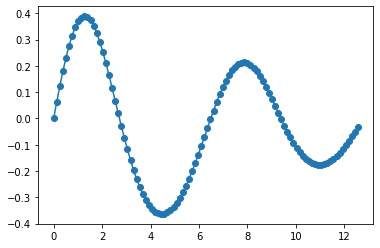

In [16]:
plt.plot(t, x, '-o');

In [17]:
from denn.utils import Generator
from denn.nlo.mse_nlo import train_MSE

N_ITERS = 10000
N_HIDDEN = 64
N_LAYERS = 8
N_PERIODS = 4

### Supervised

Numerical solution success: True


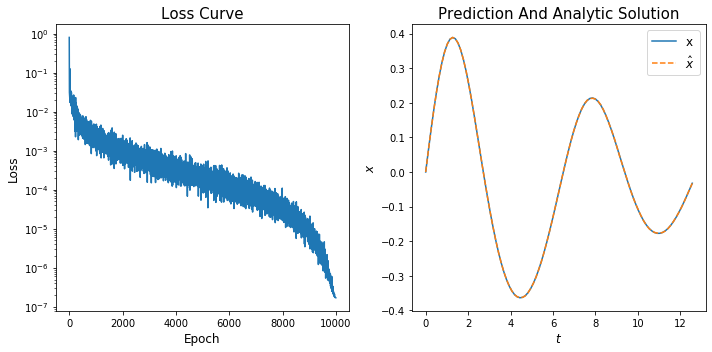

Final MSE: 1.7003135610593745e-07


In [8]:
resgnet = Generator(n_hidden_units=N_HIDDEN, n_hidden_layers=N_LAYERS, residual=True, output_tan=True)
sup_res = train_MSE(resgnet, method='supervised', niters=N_ITERS, nperiods=N_PERIODS, make_plot=True)

#### Observers every 10

Numerical solution success: True


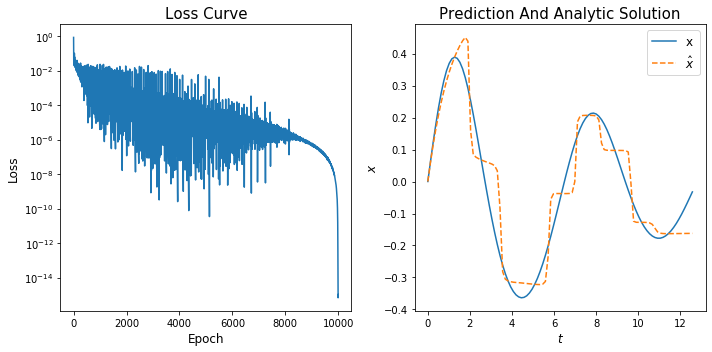

Final MSE: 0.004814718849956989


In [18]:
resgnet = Generator(n_hidden_units=N_HIDDEN, n_hidden_layers=N_LAYERS, residual=True, output_tan=True)
sup_res = train_MSE(resgnet, method='supervised', niters=N_ITERS, nperiods=N_PERIODS, observe_every=10, make_plot=True)

## Semi-Supervised

Numerical solution success: True


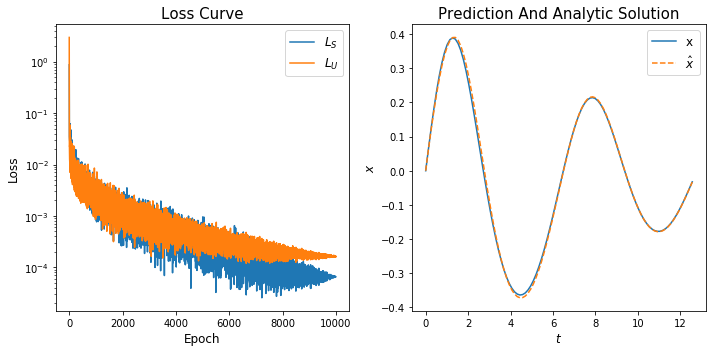

Final MSE: 6.528868834720924e-05


In [20]:
resgnet = Generator(n_hidden_units=N_HIDDEN, n_hidden_layers=N_LAYERS, residual=True, output_tan=True)
semisup_res = train_MSE(resgnet, method='semisupervised', niters=N_ITERS, nperiods=N_PERIODS, make_plot=True)

#### Observe every = 10

Numerical solution success: True


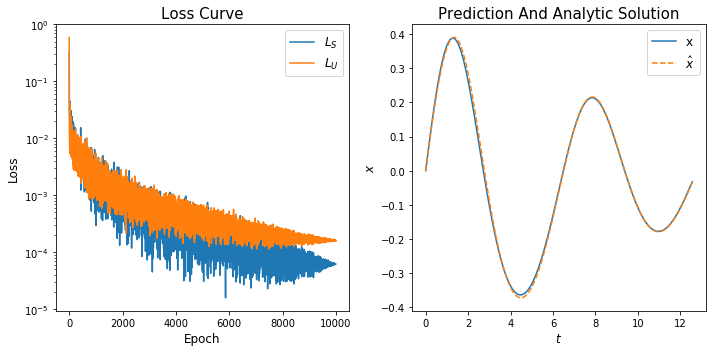

Final MSE: 6.809699698351324e-05


In [19]:
resgnet = Generator(n_hidden_units=N_HIDDEN, n_hidden_layers=N_LAYERS, residual=True)
semisup_res = train_MSE(resgnet, method='semisupervised', niters=N_ITERS, nperiods=N_PERIODS, make_plot=True, observe_every=10)

## Unsupervised

Numerical solution success: True


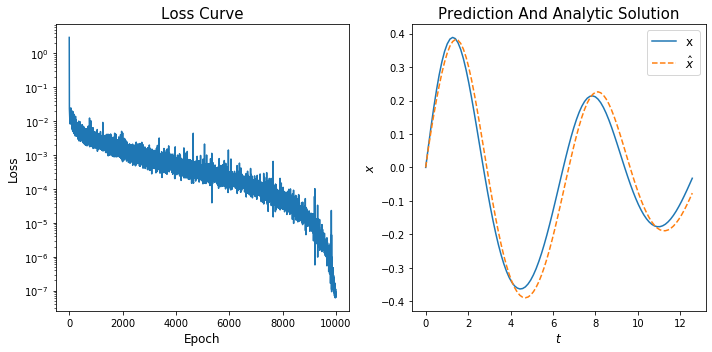

Final MSE: 0.0018424170557409525


In [10]:
resgnet = Generator(n_hidden_units=N_HIDDEN, n_hidden_layers=N_LAYERS, residual=True, output_tan=True)
unsup_res = train_MSE(resgnet, method='unsupervised', niters=N_ITERS, nperiods=N_PERIODS, make_plot=True)

## GAN

Numerical solution success: True


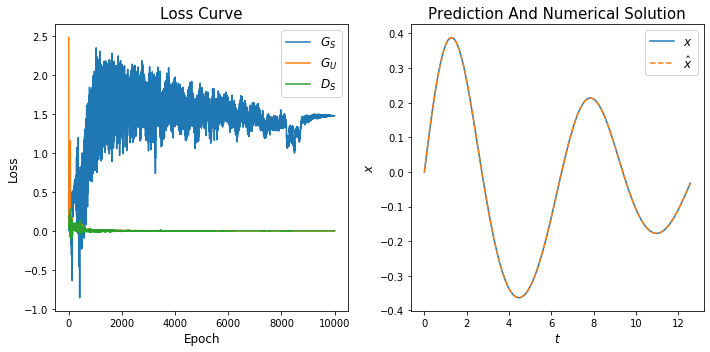

Final MSE: 1.5596130253925367e-07


In [5]:
D = Discriminator(in_dim=2, out_dim=1,
                      n_hidden_units=32,
                      n_hidden_layers=8,
                      activation=nn.Tanh(),
                      unbounded=True,   # true for WGAN
                      residual=True)

G = Generator(in_dim=1, out_dim=1,
              n_hidden_units=64,
              n_hidden_layers=8,
              activation=nn.Tanh(), # twice diff'able activation
              output_tan=True,      # true output range should be (-1,1) if True
              residual=True)

res = train_GAN_NLO(G, D, num_epochs=10000, final_plot=True)

Numerical solution success: True


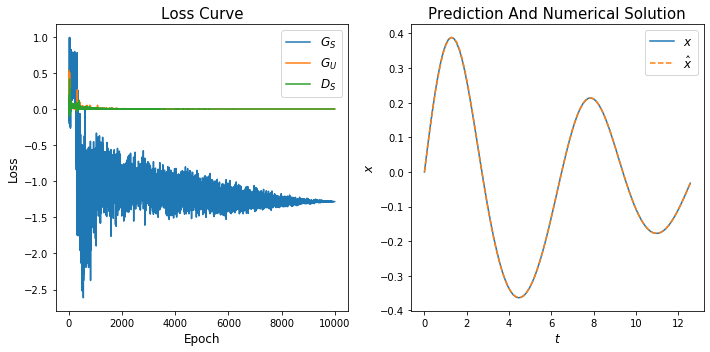

Final MSE: 1.2235277608851902e-06


In [21]:
D = Discriminator(in_dim=2, out_dim=1,
                      n_hidden_units=32,
                      n_hidden_layers=8,
                      activation=nn.Tanh(),
                      unbounded=True,   # true for WGAN
                      residual=True)

G = Generator(in_dim=1, out_dim=1,
              n_hidden_units=64,
              n_hidden_layers=8,
              activation=nn.Tanh(), # twice diff'able activation
              output_tan=True,      # true output range should be (-1,1) if True
              residual=True)

res = train_GAN_NLO(G, D, num_epochs=10000, observe_every=10, final_plot=True)

# Observe Every X Experiment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('axes', titlesize=15, labelsize=12)
plt.rc('legend', fontsize=12)

In [2]:
gan = pd.read_csv('~/Downloads/GAN_obsevery_mse_results_NLO.csv', index_col=0)
lag = pd.read_csv('~/Downloads/LAG_obsevery_mse_results_NLO.csv', index_col=0)
sup = pd.read_csv('~/Downloads/SUP_obsevery_mse_results_NLO.csv', index_col=0)

In [3]:
gan = gan.sort_values(by='obs_every')
lag = lag.sort_values(by='obs_every')
sup = sup.sort_values(by='obs_every')

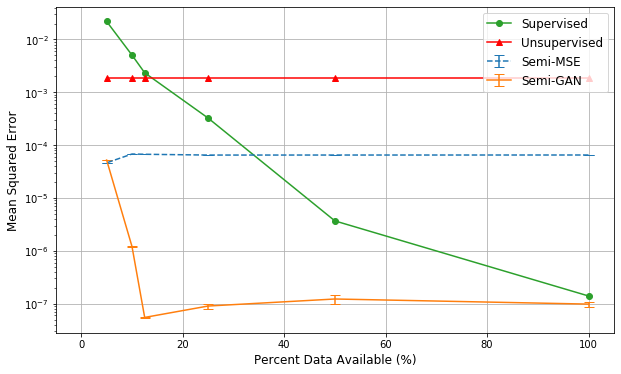

In [7]:
plt.figure(figsize=(10,6))
plt.errorbar(100/lag.obs_every, lag.mse_mean, fmt='--', yerr=lag.mse_std/2, capsize=5, label='Semi-MSE')
plt.errorbar(100/gan.obs_every, gan.mse_mean, yerr=gan.mse_std/2, capsize=5, label='Semi-GAN')
plt.plot(100/sup.obs_every, sup.mse_mean, '-o', label='Supervised')
plt.plot(100/lag.obs_every, [0.0018424170557409525 for _ in lag.obs_every], '-^', color='r', label='Unsupervised')
plt.yscale('log')
plt.xlabel('Percent Data Available (%)')
# plt.xlim(105, 0)
plt.xlim(-5, 105)
plt.grid()
plt.ylabel('Mean Squared Error')
# plt.title('Comparison of Methods: MSE vs Available Data')
plt.legend()
plt.savefig('ExperimentResult_ObsEvery_NLO.png');